<a href="https://colab.research.google.com/github/kartickgupta/multilabel-text-classification-BERT/blob/main/Multilabel_Text_Classification_using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [138]:
import tensorflow as tf
import pandas as pd
import numpy as np
from google.colab import drive
from tensorflow.keras.layers import LSTM, Embedding, Dense, Flatten
from tensorflow.keras.utils import to_categorical
import os
import datetime
import re
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
!pip install -q tf-models-official
!pip install -q -U tensorflow-text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
import tensorflow_hub as hub
import tensorflow_text as tf_text
from official.nlp import optimization  # to create AdamW optimizer


In [139]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [140]:
with open('/content/drive/My Drive/India.csv', 'r') as f:
    india_df = pd.read_csv(f, delimiter=';')


In [141]:
india_df.head()

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,assoc_actor_1,inter1,interaction,region,country,admin1,admin2,admin3,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3
0,8384005,356,IND96785,96785,09 July 2021,2021,1,Protests,Peaceful protest,Protesters (India),LPF: Labour Progressive Federation; Labour Gro...,6,60,South Asia,India,Tamil Nadu,Krishnagiri,Krishnagiri,Krishnagiri,12.5192,78.2138,1,The Hindu,National,"On 9 July 2021, members of the LPF and DMK hel...",0,1626212811,IND
1,8383761,356,IND96773,96773,09 July 2021,2021,1,Protests,Peaceful protest,Protesters (India),Fishermen (India),6,60,South Asia,India,Karnataka,Dakshina Kannada,Mangaluru,Mangaluru,12.9172,74.8560,1,Deccan Herald,Subnational,"On 9 July 2021, fishermen held a protest in Ma...",0,1626212811,IND
2,8384017,356,IND96784,96784,09 July 2021,2021,1,Protests,Peaceful protest,Protesters (India),INC: Indian National Congress,6,60,South Asia,India,Tamil Nadu,Erode,Erode,Erode,11.3428,77.7274,1,The Hindu,National,"On 9 July 2021, members of the INC held a prot...",0,1626212811,IND
3,8383769,356,IND96763,96763,09 July 2021,2021,1,Protests,Protest with intervention,Protesters (India),Bajrang Dal,6,16,South Asia,India,Jammu and Kashmir,Jammu,Jammu,Jammu,32.7357,74.8691,1,Greater Kashmir,Subnational,"On 9 July 2021, police intervened to stop Bajr...",0,1626212811,IND
4,8383769,356,IND96763,96763,09 July 2021,2021,1,Protests,Protest with intervention,Police Forces of India (2014-),NaN,1,16,South Asia,India,Jammu and Kashmir,Jammu,Jammu,Jammu,32.7357,74.8691,1,Greater Kashmir,Subnational,"On 9 July 2021, police intervened to stop Bajr...",0,1626212811,IND


## Text Preprcessing


*   Removing noise from the end of every headline.
*   Removing Dates and Months.
*   Removing Comma (,) from the begining.
*   Stripping extra unwanted the space.




In [142]:
# Remove Excess [Size:: ] from EoS
def remove_size(text):
	result = re.search("\[size", text)
	if result is not None:
		text = text[:result.start()]
	return text.strip()

months = ['january', 'jan', 'feb', 'mar', 'apr', 'aug', 'sept', 'oct', 'nov', 'dec', 'feburary', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'on']
def remove_months(text):
    text = text.split()
    text = [word for word in text if word.lower() not in set(months)]
    text = ' '.join(text)
    return text

def remove_nums(text):
    result = re.sub(r'[0-9+]', '', text)
    return result

def remove_comma(text):
    result = re.sub(r',', '', text)
    return result

india_df['notes'] = india_df['notes'].apply(remove_comma)
india_df['notes'].head()

0    On 9 July 2021 members of the LPF and DMK held...
1    On 9 July 2021 fishermen held a protest in Man...
2    On 9 July 2021 members of the INC held a prote...
3    On 9 July 2021 police intervened to stop Bajra...
4    On 9 July 2021 police intervened to stop Bajra...
Name: notes, dtype: object

In [143]:
def text_cleaning(text):
    text = remove_size(text)
    text = remove_nums(text)
    text = remove_months(text)
    text = remove_comma(text)
    return text.strip()

india_df['notes'] = india_df['notes'].apply(text_cleaning)

### Date conversion from text to datetime (DD-MM-YYYY) format.

In [144]:
# Convert Date from to datetime format
from datetime import datetime

def text_to_date(d):
    d = d[: -5] + ', ' + d[-4:]
    return datetime.strptime(d, "%d %B, %Y").strftime('%d-%m-%Y')

india_df['event_date'] = india_df['event_date'].apply(text_to_date)

In [145]:
india_df['notes'].head()

0    members of the LPF and DMK held a protest in K...
1    fishermen held a protest in Mangaluru city (Ma...
2    members of the INC held a protest in Erode cit...
3    police intervened to stop Bajrang Dal members ...
4    police intervened to stop Bajrang Dal members ...
Name: notes, dtype: object

In [146]:
india_df = india_df.drop_duplicates()

In [147]:
india_df.shape

(77815, 28)

In [148]:
india_df.sub_event_type.unique()

array(['Peaceful protest', 'Protest with intervention', 'Armed clash',
       'Mob violence', 'Attack', 'Looting/property destruction',
       'Violent demonstration', 'Grenade', 'Disrupted weapons use',
       'Change to group/activity', 'Air/drone strike', 'Agreement',
       'Arrests', 'Sexual violence', 'Remote explosive/landmine/IED',
       'Excessive force against protesters', 'Other',
       'Abduction/forced disappearance',
       'Shelling/artillery/missile attack', 'Suicide bomb',
       'Headquarters or base established',
       'Non-violent transfer of territory'], dtype=object)

In [149]:
'''ABDUCT_DISSAP
AGREEMENT
AIR_STRIKE
ARMED_CLASH
ARREST
ART_MISS_ATTACK
ATTACK
CHANGE_TO_GROUP_ACT
CHEM_WEAP
DISR_WEAP
FORCE_AGAINST_PROTEST
GOV_REGAINS_TERIT
GRENADE
HQ_ESTABLISHED
MOB_VIOL
NON_STATE_ACTOR_OVERTAKES_TER
NON_VIOL_TERRIT_TRANSFER
OTHER
PEACE_PROTEST
PROPERTY_DISTRUCT
PROTEST_WITH_INTER
REM_EXPLOS
SEX_VIOL
SUIC_BOMB
VIOL_DEMONSTR''';

## Target Label Prepration

In [150]:
event_types_dict = {}
for num, name in enumerate(list(india_df['sub_event_type'].unique())):
    event_types_dict[name] = num
    # print(name, " : ", num)

event_types_dict

{'Abduction/forced disappearance': 17,
 'Agreement': 11,
 'Air/drone strike': 10,
 'Armed clash': 2,
 'Arrests': 12,
 'Attack': 4,
 'Change to group/activity': 9,
 'Disrupted weapons use': 8,
 'Excessive force against protesters': 15,
 'Grenade': 7,
 'Headquarters or base established': 20,
 'Looting/property destruction': 5,
 'Mob violence': 3,
 'Non-violent transfer of territory': 21,
 'Other': 16,
 'Peaceful protest': 0,
 'Protest with intervention': 1,
 'Remote explosive/landmine/IED': 14,
 'Sexual violence': 13,
 'Shelling/artillery/missile attack': 18,
 'Suicide bomb': 19,
 'Violent demonstration': 6}

### Text to Numerical Labeling 

In [151]:
def text_to_numerical_category(name):
    num = event_types_dict[name]
    return num

print(text_to_numerical_category('Peaceful protest'))
india_df['sub_event_type'] = india_df['sub_event_type'].apply(text_to_numerical_category)

0


In [152]:
india_df.head()

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,assoc_actor_1,inter1,interaction,region,country,admin1,admin2,admin3,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3
0,8384005,356,IND96785,96785,09-07-2021,2021,1,Protests,0,Protesters (India),LPF: Labour Progressive Federation; Labour Gro...,6,60,South Asia,India,Tamil Nadu,Krishnagiri,Krishnagiri,Krishnagiri,12.5192,78.2138,1,The Hindu,National,members of the LPF and DMK held a protest in K...,0,1626212811,IND
1,8383761,356,IND96773,96773,09-07-2021,2021,1,Protests,0,Protesters (India),Fishermen (India),6,60,South Asia,India,Karnataka,Dakshina Kannada,Mangaluru,Mangaluru,12.9172,74.8560,1,Deccan Herald,Subnational,fishermen held a protest in Mangaluru city (Ma...,0,1626212811,IND
2,8384017,356,IND96784,96784,09-07-2021,2021,1,Protests,0,Protesters (India),INC: Indian National Congress,6,60,South Asia,India,Tamil Nadu,Erode,Erode,Erode,11.3428,77.7274,1,The Hindu,National,members of the INC held a protest in Erode cit...,0,1626212811,IND
3,8383769,356,IND96763,96763,09-07-2021,2021,1,Protests,1,Protesters (India),Bajrang Dal,6,16,South Asia,India,Jammu and Kashmir,Jammu,Jammu,Jammu,32.7357,74.8691,1,Greater Kashmir,Subnational,police intervened to stop Bajrang Dal members ...,0,1626212811,IND
4,8383769,356,IND96763,96763,09-07-2021,2021,1,Protests,1,Police Forces of India (2014-),NaN,1,16,South Asia,India,Jammu and Kashmir,Jammu,Jammu,Jammu,32.7357,74.8691,1,Greater Kashmir,Subnational,police intervened to stop Bajrang Dal members ...,0,1626212811,IND


In [154]:
india_df.notes.shape

(77815,)

### One Hot Encoding the Target Labels

In [155]:
encoded_events = to_categorical(india_df.sub_event_type, num_classes = len(event_types_dict))
encoded_events.shape

(77815, 22)

## Shuffle Dataset

In [153]:
from sklearn.utils import shuffle
india_df = shuffle(india_df)
india_df.head()

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,assoc_actor_1,inter1,interaction,region,country,admin1,admin2,admin3,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3
64057,5595965,356,IND43711,43711,13-01-2019,2019,1,Protests,0,Protesters (India),NaN,6,60,South Asia,India,Uttar Pradesh,Lucknow,Lucknow,Lucknow,26.8392,80.9231,1,Times of India,National,family members of a cloth merchant who was fou...,0,1563366757,IND
48599,5549765,356,IND57090,57090,02-07-2019,2019,1,Protests,0,Protesters (India),Farmers (India); INC: Indian National Congress,6,60,South Asia,India,Gujarat,Gandhinagar,Gandhinagar,Gandhinagar,23.2166,72.6833,2,Indian Express,National,INC and farmers with about vehicles reached Ga...,0,1562671722,IND
78171,7048503,356,IND33193,33193,15-07-2018,2018,1,Battles,2,CPI (Maoist): Communist Party of India (Maoist),NaN,2,12,South Asia,India,Chhattisgarh,Kanker,Pakhanjur,Partapur,19.9470,80.7325,2,Pioneer (India),National,near Partapaur village of Koilebeda tehsil (Ka...,2,1618534289,IND
4865,7802932,356,IND92135,92135,02-04-2021,2021,1,Protests,0,Protesters (India),MP: Women Torch Bearers; Women (India),6,60,South Asia,India,Manipur,Imphal West,Lamphelpat,Imphal,24.7908,93.9302,1,Imphal Free Press,Subnational,Meira Paibis women's groups and local clubs st...,0,1618480261,IND
24015,7137893,356,IND76239,76239,24-06-2020,2020,2,Riots,3,Rioters (India),Bharatpur Communal Militia (India),5,55,South Asia,India,Punjab,SAS Nagar,Kharar,Bharatpur,30.6597,76.6564,1,Chandigarh Tribune,Subnational,Around groups clashed in Bharatpur village SAS...,0,1618500716,IND


## Input Pipeline

In [156]:
tf_dataset = tf.data.Dataset.from_tensor_slices((india_df.notes, encoded_events)).batch(32)

In [157]:
tf_dataset

<BatchDataset shapes: ((None,), (None, 22)), types: (tf.string, tf.float32)>

### Train, Val, Test Split

**NOTE ::** Do the spiltting in terms of bache_size instead of number of training samples

In [158]:
split_size = 0.8

train_size = int( (india_df.shape[0]/32)* split_size)
train_data = tf_dataset.take(train_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_test_data = tf_dataset.skip(train_size).prefetch(buffer_size=tf.data.AUTOTUNE)

val_data = val_test_data.take(int(len(val_test_data)/2)).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = val_test_data.skip(int(len(val_test_data)/2)).prefetch(buffer_size=tf.data.AUTOTUNE)
print(f"Total Number Samples : {india_df.shape[0]}")
print(f"Number of Training Samples : {len(train_data)*32}")
print(f"Number of Validation Samples : {len(val_data)*32}")
print(f"Number of Test Samples : {len(test_data)*32}")


Total Number Samples : 77815
Number of Training Samples : 62240
Number of Validation Samples : 7776
Number of Test Samples : 7808


In [159]:
train_data

<PrefetchDataset shapes: ((None,), (None, 22)), types: (tf.string, tf.float32)>

In [160]:
for feat, targ in train_data.take(1):
  print ('Features: {}, Target: {}'.format(feat, targ.numpy()))

Features: [b'family members of a cloth merchant who was found murdered earlier in the day staged a protest and blocked Rae Bareli Rd in Lucknow city (Lucknow Uttar Pradesh) protesting against police and demanding quick action in the case.'
 b'INC and farmers with about vehicles reached Gandhinagar (Gandhinagar Gujarat) during their three-day tractor from Gandhidham to Gandhinagar against adulteration in groundnut stock.'
 b'near Partapaur village of Koilebeda tehsil (Kanker Chhattisgarh) BSF and Maoists engaged in a gun battle. Two BSF were killed and one was injured.'
 b"Meira Paibis women's groups and local clubs staged a sit-in protest at Imphal (Manipur) to protest against a death of a local under unknown circumstances."
 b'Around groups clashed in Bharatpur village SAS Nagar (Punjab) over a land dispute. people injured.'
 b'about Naxalites disguised as farmers held hostage drivers of vehicles engaged in road construction work in Kirandul (Dantewada Chhattisgarh) and later torched 

## BERT Model : bert_multi_cased_L-12_H-768_A-12

In [161]:
bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'
bert_model_link = 'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3'
bert_model_preprocessing_link = 'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3'

### Bert Preprocessing

In [162]:
bert_preprocess_model = hub.KerasLayer(bert_model_preprocessing_link)

In [163]:
sample_text = [india_df['notes'][0]]
print(sample_text)
text_preprocessed = bert_preprocess_model(sample_text)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

['members of the LPF and DMK held a protest in Krishnagiri city (Krishnagiri TN) against the increase in fuel prices.']
Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 1484 1104 1103 6400 2271 1105  141 2107 2428 1316  170]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [164]:
bert_model = hub.KerasLayer(bert_model_link)


In [165]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {bert_model_link}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.48017055  0.27977386  0.9972236  -0.92582536  0.8515523   0.9136475
  0.8063637  -0.995688   -0.78384775 -0.506987    0.83931243  0.97599435]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.07697573  0.04790553 -0.31953815 ... -0.17531687 -0.1265651
  -0.13930571]
 [ 0.28581423 -0.34836382  0.23534177 ... -0.26433396 -0.23449574
  -0.3981651 ]
 [-0.8126637  -0.06740195 -0.69057286 ... -0.00551546 -0.91304016
  -0.8927016 ]
 ...
 [-0.4704089  -0.05547929 -0.3736198  ...  0.40809712 -0.50220424
   0.07352842]
 [-0.13602102 -0.19971237 -0.02561866 ...  0.5829852  -0.4123639
  -0.1699388 ]
 [-0.14933826  0.04764217 -0.09060752 ...  0.27990076 -0.0172012
  -0.5347244 ]]


### Building the BERT Model

In [166]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype = tf.string, name='input-text')
    preprocessing_layer = hub.KerasLayer(bert_model_preprocessing_link, name='bert-preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(bert_model_link, trainable=False, name='bert-encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = Dense(units= 512, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = Dense(units=len(list(india_df['sub_event_type'].unique())), activation='softmax', name='classifer')(net)
    return tf.keras.Model(text_input, net)


In [167]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(sample_text))

In [168]:
classifier_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input-text (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
bert-preprocessing (KerasLayer) {'input_mask': (None 0           input-text[0][0]                 
__________________________________________________________________________________________________
bert-encoder (KerasLayer)       {'pooled_output': (N 108310273   bert-preprocessing[0][0]         
                                                                 bert-preprocessing[0][1]         
                                                                 bert-preprocessing[0][2]         
____________________________________________________________________________________________

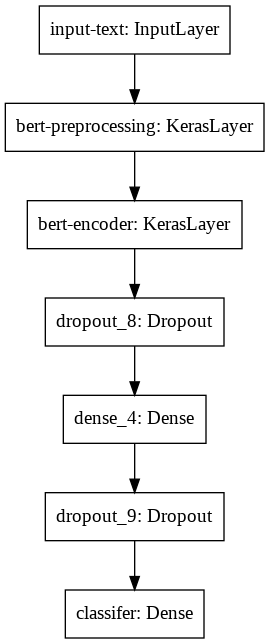

In [169]:
tf.keras.utils.plot_model(classifier_model)

In [170]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = tf.metrics.CategoricalAccuracy()

In [171]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_data).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

## Model Compilation

In [172]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

## Model Training

In [173]:
print(f'Training model with {bert_model_link}')
history = classifier_model.fit(x= train_data,
                               validation_data= test_data,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3
Epoch 1/5
1945/1945 [==============================] - 716s 364ms/step - loss: 1.5134 - categorical_accuracy: 0.5460 - val_loss: 1.2094 - val_categorical_accuracy: 0.5879
Epoch 2/5
1945/1945 [==============================] - 706s 363ms/step - loss: 1.1779 - categorical_accuracy: 0.6250 - val_loss: 1.0630 - val_categorical_accuracy: 0.6553
Epoch 3/5
1945/1945 [==============================] - 705s 363ms/step - loss: 1.0820 - categorical_accuracy: 0.6542 - val_loss: 0.9995 - val_categorical_accuracy: 0.6712
Epoch 4/5
1945/1945 [==============================] - 705s 363ms/step - loss: 1.0348 - categorical_accuracy: 0.6679 - val_loss: 0.9677 - val_categorical_accuracy: 0.6834
Epoch 5/5
1945/1945 [==============================] - 707s 364ms/step - loss: 1.0152 - categorical_accuracy: 0.6740 - val_loss: 0.9567 - val_categorical_accuracy: 0.6835


### Plotting Metrics : Accuracy and Loss

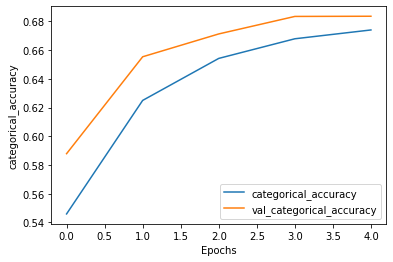

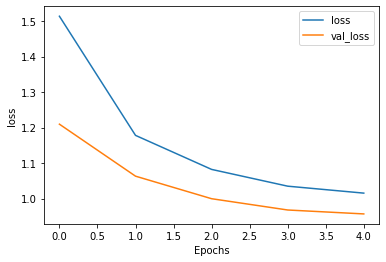

In [174]:
import matplotlib.pyplot as plt 
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "categorical_accuracy")
plot_graphs(history, 'loss')


## Exporting the Model

In [176]:
model.save('bert-text-classifier.h5') 

## Evaluation on Test Data

In [177]:
loss, acc = model.evaluate(train_data)

1945/1945 [==============================] - 626s 322ms/step - loss: 0.9038 - categorical_accuracy: 0.7001


In [236]:
test_data_list = list(test_data.unbatch().as_numpy_iterator())

In [237]:
test_text = []
test_label = []
for text, label in test_data_list:
    test_text.append(text)
    test_label.append(label)

In [218]:
y_pred = model.predict(test_text)

In [175]:
from sklearn.metrics import classification_report

In [226]:
inverse_dict = {v:k for k, v in sorted(event_types_dict.items(), key=lambda item: item[1])}
list(inverse_dict.values())

['Peaceful protest',
 'Protest with intervention',
 'Armed clash',
 'Mob violence',
 'Attack',
 'Looting/property destruction',
 'Violent demonstration',
 'Grenade',
 'Disrupted weapons use',
 'Change to group/activity',
 'Air/drone strike',
 'Agreement',
 'Arrests',
 'Sexual violence',
 'Remote explosive/landmine/IED',
 'Excessive force against protesters',
 'Other',
 'Abduction/forced disappearance',
 'Shelling/artillery/missile attack',
 'Suicide bomb',
 'Headquarters or base established',
 'Non-violent transfer of territory']

In [238]:
test_label = np.argmax(np.array(test_label), axis=1)
y_preds = np.argmax(np.array(y_pred), axis=1)
print(test_label, y_preds)

[0 3 0 ... 0 0 0] [0 3 0 ... 0 0 0]


### Classification Report

In [241]:
print(classification_report(y_true=test_label, y_pred=y_preds))

              precision    recall  f1-score   support

           0       0.78      0.99      0.87      4250
           1       0.80      0.05      0.10       554
           2       0.68      0.66      0.67       549
           3       0.45      0.67      0.54      1165
           4       0.73      0.08      0.14       457
           5       0.00      0.00      0.00        38
           6       0.34      0.06      0.10       530
           7       0.00      0.00      0.00        32
           8       0.00      0.00      0.00        84
           9       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         8
          12       0.00      0.00      0.00        20
          13       0.00      0.00      0.00        26
          14       0.00      0.00      0.00        60
          15       0.00      0.00      0.00         4
          17       0.00      0.00      0.00        17

    accuracy                           0.70      7799
   macro avg       0.24   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [254]:
print("Training Accuracy :   {:.2f} %        Training Loss : {:.2f}".format(history.history['categorical_accuracy'][-1]*100, history.history['loss'][-1]))
print("Validation Accuracy : {:.2f} %      Validation Loss : {:.2f}".format(history.history['val_categorical_accuracy'][-1]*100, history.history['val_loss'][-1]))
print("Test Accuracy :       {:.2f} %            Test Loss : {:.2f}".format(acc*100, loss))

Training Accuracy :   67.40 %        Training Loss : 1.02
Validation Accuracy : 68.35 %      Validation Loss : 0.96
Test Accuracy :       70.01 %            Test Loss : 0.90
